In [94]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
from scipy.stats import gaussian_kde
import seaborn as sns

def seven_games(p,q):
    print(p**4 * (1+4*q+10*q**2+20*q**3))

In [82]:
#constants
avg_warriors_fgs = 40.3
warriors_attempted_3 = 525
warriors_total_attempted_fg = 1476
warriors_free_throws_made = 304
warriors_free_throws_attempted = 414

warriors_fg_data = np.array([39,40,34,46,45,43,42,42,44,43,40,43,38,33,40,36,37])
warriors_fg_allowed = np.array([30,35,36,33,31,39,36,40,43,38,39,35,46,39,39,38,34])


avg_cavs_fgs = 38.7
cavs_attempted_3 = 465
cavs_total_attempted_fg = 1140
cavs_free_throws_made = 211
cavs_free_throws_attempted = 291
cavs_fg_data = np.array([39,40,39,36,37,41,42,38,41,38,28,39,44,40])
cavs_fg_allowed = np.array([37,34,36,37,33,30,41,40,32,33,38,42,27,33])


In [83]:
warriors_mu = pm.Normal('warriors_mu',avg_warriors_fgs,1/16.0)
warriors_tau = 1.0/pm.Uniform('warriors_tau',1,10)**2
warriors_obs = pm.Normal('warriors_obs',warriors_mu,warriors_tau,value=warriors_fg_data,
                        observed=True)

warriors_3_percentage = pm.Beta('warriors_3_percentage',warriors_attempted_3+1,
                               warriors_total_attempted_fg-warriors_attempted_3+1)

warriors_attempted_free_throw = pm.DiscreteUniform('warriors_free_throw',11,33)
warriors_percent_free_throw = pm.Beta('warriors_completed_free_throw',warriors_free_throws_made+1,
                                     warriors_free_throws_attempted-warriors_free_throws_made+1)
warriors_free_throw_binom = pm.Binomial('warriors_free_throw_binom',
                                        warriors_attempted_free_throw,
                                        warriors_percent_free_throw)

cavs_defense_modifier = pm.Normal('cavs_defense_modifier',cavs_fg_allowed.mean(),1/16.0)
cavs_observed_defense = pm.Normal('cavs_observed_defense',cavs_fg_allowed.mean(),1/16.0,
                                  value=cavs_fg_allowed,observed=True)

@pm.deterministic
def defense_points(warriors_mu = warriors_mu,
          warriors_free_throw_binom=warriors_free_throw_binom,
          warriors_3_percentage=warriors_3_percentage,
          cavs_defense_modifier=cavs_defense_modifier):
    x = warriors_3_percentage
    y = warriors_mu
    z = cavs_defense_modifier
    return .7*((x*y*3) + (y*(1-x)*2)) + .3*((x*z*3) + (z*(1-x)*2)) + warriors_free_throw_binom

@pm.deterministic
def points(warriors_mu = warriors_mu,
          warriors_free_throw_binom=warriors_free_throw_binom,
          warriors_3_percentage=warriors_3_percentage):
    x = warriors_3_percentage
    y = warriors_mu
    return (x*y*3) + (y*(1-x)*2) + warriors_free_throw_binom

warriors_mcmc_defense = pm.MCMC([warriors_mu,warriors_tau,warriors_obs,warriors_attempted_free_throw,
                warriors_percent_free_throw,warriors_free_throw_binom,warriors_3_percentage,
                defense_points,cavs_defense_modifier,cavs_observed_defense])

warriors_mcmc = pm.MCMC([warriors_mu,warriors_tau,warriors_obs,warriors_attempted_free_throw,
                warriors_percent_free_throw,warriors_free_throw_binom,warriors_3_percentage,
                points])

In [84]:
cavs_mu = pm.Normal('cavs_,cavs_defenmu',avg_cavs_fgs,1/25.0)
cavs_tau = 1.0/pm.Uniform('cavs_tau',1,10)**2
cavs_obs = pm.Normal('cavs_obs',cavs_mu,cavs_tau,value=cavs_fg_data,
                       observed=True)

cavs_3_percentage = pm.Beta('cavs_3_percentage',cavs_attempted_3+1,
                              cavs_total_attempted_fg-cavs_attempted_3+1)

cavs_attempted_free_throw = pm.DiscreteUniform('cavs_attempted_free_throw',7,30)
cavs_percent_free_throw = pm.Beta('cavs_completed_free_throw',cavs_free_throws_made+1,
                                    cavs_free_throws_attempted-cavs_free_throws_made+1)
cavs_free_throw_binom = pm.Binomial('cavs_free_throw_binom',cavs_attempted_free_throw,
                                      cavs_percent_free_throw)

warriors_defense_modifier = pm.Normal('warriors_defense_modifier',warriors_fg_allowed.mean(),1/16.0)
warriors_observed_defense = pm.Normal('warriors_observed_defense',warriors_fg_allowed.mean(),1/16.0,
                                      value=warriors_fg_allowed,observed=True)

@pm.deterministic
def cavs_defense_points(cavs_mu = cavs_mu,
           cavs_free_throw_binom = cavs_free_throw_binom,
           cavs_3_percentage = cavs_3_percentage,
           warriors_defense_modifier=warriors_defense_modifier):
    x = cavs_3_percentage
    y = cavs_mu
    z = warriors_defense_modifier
    return .7*((x*y*3) + (y*(1-x)*2)) + .3*((x*z*3) + (z*(1-x)*2)) + cavs_free_throw_binom

@pm.deterministic
def cavs_points(cavs_mu = cavs_mu,
           cavs_free_throw_binom = cavs_free_throw_binom,
           cavs_3_percentage = cavs_3_percentage):
    x = cavs_3_percentage
    y = cavs_mu
    return (x*y*3) + (y*(1-x)*2) + cavs_free_throw_binom

cavs_mcmc_defense = pm.MCMC([cavs_mu,cavs_tau,cavs_obs,cavs_attempted_free_throw,
                       cavs_percent_free_throw,cavs_free_throw_binom,cavs_3_percentage,cavs_defense_points,
                    warriors_defense_modifier,warriors_observed_defense])

cavs_mcmc = pm.MCMC([cavs_mu,cavs_tau,cavs_obs,cavs_attempted_free_throw,
                       cavs_percent_free_throw,cavs_free_throw_binom,cavs_3_percentage,cavs_points])

In [85]:
warriors_mcmc.sample(50000,10000)
warriors_mcmc_defense.sample(50000,10000)
tracer = warriors_mcmc.trace('points')[:]
tracer_defense = warriors_mcmc_defense.trace('defense_points')[:]

cavs_mcmc.sample(50000,10000)
cavs_mcmc_defense.sample(50000,10000)
cavs_tracer = cavs_mcmc.trace('cavs_points')[:]
cavs_tracer_defense = cavs_mcmc_defense.trace('cavs_defense_points')[:]

 [-----------------100%-----------------] 50000 of 50000 complete in 99.1 sec

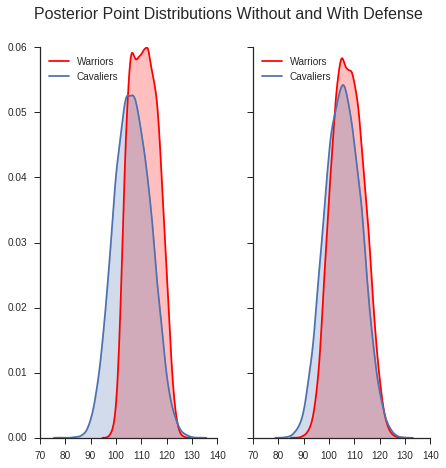

In [86]:
sns.set(style='ticks')
f, axes = plt.subplots(1, 2, figsize=(7, 7),sharey=True)
sns.despine()
sns.distplot(tracer,hist=False,color='red',label='Warriors',ax=axes[0],kde_kws = {"shade":True})
sns.distplot(tracer_defense,hist=False,color='red',label='Warriors',ax=axes[1],kde_kws={"shade":True})
sns.distplot(cavs_tracer,hist=False,kde_kws={"shade":True},ax=axes[0],label='Cavaliers')
sns.distplot(cavs_tracer_defense,hist=False,kde_kws={"shade":True},ax=axes[1],label='Cavaliers')
plt.suptitle('Posterior Point Distributions Without and With Defense',fontsize=16)
plt.savefig('2016_NBA_Finals_Posterior_Point_Distributions.png')

In [102]:
np.std(tracer_defense - cavs_tracer_defense)

9.1931715764489663